# Embeddings con LSTM



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import random
from itertools import chain
from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
cd ..

c:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal


In [3]:
from helpers.boletines import get_sentences

In [4]:
cd Embeddings/

c:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal\Embeddings


## Definición de constantes

In [2]:
# Número de GPUs disponibles. Usar 0 para modo CPU.
ngpu = 1

# Semilla a usar en los generadores de números aleatorios
SEED = 42069
# SEED = random.randint(1, 10000) # En caso de requerir más resultados
random.seed(SEED)
torch.manual_seed(SEED)

print("Random Seed: ", SEED)

Random Seed:  42069


Selecciono el tipo de dispositivo a utilizar (gpu o cpu)

In [3]:
# Decide si queremos correr en gpu o cpu
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Obtener corpus

In [7]:
uri = open('./../mongo_uri.txt', 'r', encoding='utf-8').read()

In [8]:
sentences = get_sentences(uri)

AMLO
1. Asegura AMLO que en campaña todo será amor y paz , que los otros candidatos se ahorren sus provocaciones .
377. “ Y tiene que ver con la alianza de el PRI y de el PAN , no hay que olvidar que los de el PRI , los de el PAN , los de el PRIAN se pusieron de acuerdo para nombrar a los consejeros de el INE , que tampoco son blancas palomas y también se pusieron de acuerdo para nombrar a los magistrados de el Tribunal_Electoral , yo lo denuncié en su momento ” , comentó .
753. “ Antes en las elecciones pasadas no podíamos defender nos frente_a los ataques a la guerra sucia , a las calumnias , porque nos cercaban , nos daban espacios o actuaban de manera tendenciosa en los medios convencionales , pero en esta elección la diferencia la están marcando las redes sociales , ya no pueden ” , expresó .
1129. En otro orden de ideas , informó que si hoy fuesen las elecciones ganaría con 25 puntos de ventaja , es bastante el número de mexicanos que lo apoyan , pero hay quienes crearán de maner

Desenvuelvo los grupos de enunciados en un único arreglo con todos los enunciados de todos los candidatos.

In [9]:
corpus = list(chain(*sentences.values()))

Paso los tokens a minúsculas para reducir el tamaño del vocabulario

In [10]:
corpus = [[w.lower() for w in sent] for sent in corpus]
print(f'El corpus consta de {len(corpus)} enunciados.')

El corpus consta de 6889 enunciados.


Selecciono k oraciones de prueba para el modelo

In [11]:
k = 6889
sentences = random.sample(corpus, k=k)
print('\n'.join([' '.join(sent) for sent in sentences[::k//10]]))

y se comprometió a regresar como presidente electo para traer el plan de desarrollo para uruapan para decir cuánto se invertirá en la región y regresará cada seis meses para evaluar el plan .
previamente , lópez_obrador denunció que están haciendo llamadas telefónicas a_el_por_mayor a ciudadanos para difamar lo y describió que las llamadas provienen de número telefónicos de el país y de el extranjero , es un bombardeo de llamadas .
indicó que la zona franca se mantuvo en toda la línea fronteriza en la época de porfirio_díaz , después en la revolución_mexicana , hasta que llegó carlos_salinas_de_gortari que acabó con el apoyo en la frontera .
lamentó la violencia que vive el país y confió en que a_pesar_de la situación , la gente saldrá a votar , porque tiene mucho interés en participar el 1_de_julio .
a su salida , entrevistado por los medios de comunicación , reiteró su llamado a el voto útil , invitando a las y los ciudadanos a participar libremente en el proyecto de coalición , y ce

In [286]:
# corpus juguete
sentences = open('corpus_juguete.txt', 'r', encoding='utf-8').readlines()
sentences = [s.strip().split(' ') for s in sentences]
sentences

[['el', 'gato', 'come', 'croquetas', '.'],
 ['el', 'perro', 'come', 'croquetas', '.'],
 ['el', 'gato', 'come', 'atún', '.'],
 ['el', 'perro', 'come', 'pollo', '.'],
 ['el', 'pollo', 'juega', '.'],
 ['el', 'perro', 'juega', '.'],
 ['el', 'gato', 'juega', '.'],
 ['el', 'pollo', 'juega', '.'],
 ['el', 'atún', 'come', '.'],
 ['el', 'pollo', 'come', '.'],
 ['el', 'gato', 'juega', 'con', 'el', 'perro', '.'],
 ['el', 'gato', 'juega', 'con', 'el', 'pollo', '.'],
 ['el', 'perro', 'juega', 'con', 'el', 'gato', '.'],
 ['el', 'perro', 'juega', 'con', 'el', 'pollo', '.'],
 ['el', 'pollo', 'juega', 'con', 'el', 'perro', '.'],
 ['el', 'pollo', 'juega', 'con', 'el', 'gato', '.']]

## Indexar Corpus

Cuento los tokens en todas las oraciones e imprimo los 40 más frecuentes.

In [287]:
freq = sum([Counter(sent) for sent in sentences], Counter())

In [288]:
n_tipos = len(freq.keys())
print(f'Número de tipos: {n_tipos}')
print(freq.most_common()[::max(n_tipos//25, 1)])

Número de tipos: 10
[('el', 22), ('.', 16), ('juega', 10), ('pollo', 8), ('gato', 7), ('perro', 7), ('come', 6), ('con', 6), ('croquetas', 2), ('atún', 2)]


Agrego un diccionario para pasar de palabra a índice numérico

In [289]:
w_to_index = {
    w : ix
    for ix, (w, freq) in enumerate(freq.most_common())
    if freq > 1 # No toma en cuenta los hapax
}

In [290]:
vocab_size = len(w_to_index)
vocab_size

10

In [291]:
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<UNK>'

ixBOS = vocab_size
ixEOS = vocab_size + 1
ixUNK = vocab_size + 2

In [292]:
w_to_index[BOS] = ixBOS
w_to_index[EOS] = ixEOS
w_to_index[UNK] = ixUNK

Calculo el nuevo tamaño del vocabulario después de agregar 3 tokens

In [293]:
vocab_size = len(w_to_index)
vocab_size

13

Creo el diccionario inverso, para convertir de índices a palabras

In [294]:
index_to_w = [ w for w, ix in w_to_index.items() ]

Indexo todo el corpus

In [295]:
def w_to_index_unk(w):
    """
    Le asigna el token UNK a palabras que no aparezcan en el corpus
    """
    try:
        return w_to_index[w] 
    except KeyError:
        return ixUNK

In [296]:
sentences_ix = [
    # Le agrego el inicio y fin de caracter a los enunciados
    [ixBOS] + [ w_to_index_unk(w) for w in sent ] + [ixEOS] 
    for sent in sentences
]

X = [ np.asarray(sent[:-1]) for sent in sentences_ix ]
Y = [ np.asarray(sent[1:]) for sent in sentences_ix ] 

print('Ejemplos X')
print(X[:3])
print('Ejemplos Y')
print(Y[:3])

Ejemplos X
[array([10,  0,  4,  6,  8,  1]), array([10,  0,  5,  6,  8,  1]), array([10,  0,  4,  6,  9,  1])]
Ejemplos Y
[array([ 0,  4,  6,  8,  1, 11]), array([ 0,  5,  6,  8,  1, 11]), array([ 0,  4,  6,  9,  1, 11])]


In [297]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [298]:
print(len(X_train))
print(len(X_test))

12
4


Mando los vectores de entrada y salida a tensores en gpu

In [299]:
def to_pytorch_tensor(list_of_lists):
    return [
        torch.from_numpy(l).long().to(device)
        for l in list_of_lists
    ]

In [300]:
X_train = to_pytorch_tensor(X_train)
Y_train = to_pytorch_tensor(Y_train)

X_test = to_pytorch_tensor(X_test)
Y_test = to_pytorch_tensor(Y_test)

## Modelo

### 1. Capa de embedding

### 2. Capa oculta

### 3. Capa de salida

Defino las variables para la red neuronal

In [301]:
# Dimensión de entrada (one-hot), tamaño del vocabulario
D_in = vocab_size

# Dimensión de la capa de embedding
D_emb = 2 # 32

# Dimensión de la capa lstm
D_lstm = 4 # 16

# Dimensión de la capa de salida
D_out = D_in

# Épocas de entrenamiento
num_epochs = 300

# Betas para Adam
beta1 = 0.0001
beta2 = 0.99

# Learning rate
lr =  0.1

In [302]:
class Model(nn.Module):
    def __init__(self, ngpu, D_in, D_emb, D_lstm, D_out):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(num_embeddings=D_in, embedding_dim=D_emb)#, padding_idx=0)
        self.lstm = nn.LSTM(input_size=D_emb, hidden_size=D_lstm) #, bias=True)#, batch_first=True)
        # self.out_layer = nn.Sequential(
        #     nn.Embedding(num_embeddings=D_in, embedding_dim=D_emb, padding_idx=0),
        #     nn.LSTM(input_size=D_emb, hidden_size=D_lstm, bias=True, batch_first=True),
        #     nn.Linear(in_features=D_lstm, out_features=D_out, bias=True),
        #     nn.Softmax(dim=D_out)
        # )
        self.linear = nn.Linear(in_features=D_lstm, out_features=D_out) #, bias=True)
        # self.out_layer = nn.Softmax(dim=1)
        # self.out_layer = nn.Sequential(
        #     nn.Linear(in_features=D_lstm, out_features=D_out, bias=True),
        #     nn.Softmax(dim=1)
        # )

    def forward(self, sentence):
        T = len(sentence)
        # print(sentence)
        # print(T)

        embeddings = self.embedding(sentence).view(T, 1, -1)
        # print('Embeddings')
        # print(embeddings)

        lstm_out, (ht, ct) = self.lstm(embeddings)
        lstm_out = lstm_out.view(T, -1)
        # print('LSTM_out')
        # print(lstm_out)

        preact_out = self.linear(lstm_out).view(T, -1)
        # print('Preact out')
        # print(preact_out)

        return F.log_softmax(preact_out, dim=1)
        # return self.out_layer(preact_out)

In [303]:
model = Model(ngpu, D_in, D_emb, D_lstm, D_out).to(device)
model

Model(
  (embedding): Embedding(13, 2)
  (lstm): LSTM(2, 4)
  (linear): Linear(in_features=4, out_features=13, bias=True)
)

In [304]:
# Inicialización de pesos
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Embedding') != -1:
#         # Regularizo los pesos
#         n = m.num_embeddings
#         y = 1.0/np.sqrt(n)
#         m.weight.data.uniform_(-y, y)
#     elif classname.find('Linear') != -1:
#         n = m.in_features
#         y = 1.0/np.sqrt(n)
#         m.weight.data.uniform_(-y, y)
#         m.bias.data.fill_(0)
#     elif classname.find('LSTM') != -1:
#         n = m.input_size
#         y = 1.0/np.sqrt(n)
#         m.weight_ih_l0.data.uniform_(-y, y)
#         m.weight_hh_l0.data.uniform_(-y, y)
#         m.bias_ih_l0.data.fill_(0)
#         m.bias_hh_l0.data.fill_(0)

In [305]:
# model.apply(weights_init)

Entropía cruzada como optmizador y SGD como optimizador

In [306]:
criterion = nn.NLLLoss()
criterion.to(device)
# criterion = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Entrenamiento

In [307]:
%%time
# for epoch in tqdm(range(num_epochs)):
# for epoch in range(10):
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y in zip(X_train, Y_train):
    # for x, y in tqdm(zip(X_train, Y_train)):
        if len(x) == 0:
            tqdm.write('Sentencia vacía')
            continue
        # Limpiamos gradientes acumulados
        model.zero_grad()

        # Forward
        # print(x)
        out = model(x)
        # with torch.no_grad():
        #     pred = torch.argmax(out, dim=1)
        #     print('Pred:')
        #     print(pred)
        #     print('y:')
        #     print(y)
        #     print('\n')
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # optimizer.zero_grad()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # break
    # tqdm.write(f'Epoch: {epoch:>12} Loss: {loss}')
    # break
    if epoch%20 == 0:
        print(f'Coste después de {epoch+1} épocas: {epoch_loss}')
    # if epoch%10 == 0:
    #     print(list(model.named_parameters()))

Coste después de 1 épocas: 30.45576024055481
Coste después de 21 épocas: 25.589635372161865
Coste después de 41 épocas: 19.522579312324524
Coste después de 61 épocas: 14.534743666648865
Coste después de 81 épocas: 12.211741924285889
Coste después de 101 épocas: 11.202337741851807
Coste después de 121 épocas: 10.445807933807373
Coste después de 141 épocas: 9.5938960313797
Coste después de 161 épocas: 8.77632611989975
Coste después de 181 épocas: 8.101139903068542
Coste después de 201 épocas: 7.699471652507782
Coste después de 221 épocas: 7.426285624504089
Coste después de 241 épocas: 7.220019578933716
Coste después de 261 épocas: 7.052554249763489
Coste después de 281 épocas: 6.9074128568172455
Wall time: 16.1 s


In [308]:
# list(model.named_parameters())

In [309]:
def print_ix_sentence(sentence):
    print(' '.join(index_to_w[ix] for ix in sentence.data))

In [310]:
# See what the scores are after training
with torch.no_grad():
    for sentence, y in zip(X_test[:10], Y_test[:10]):
        print('===================================================')
        print('- Probando enunciado:')
        print_ix_sentence(sentence)
        print()

        out = model(sentence)
        prediccion = torch.argmax(out, dim=1)
        print('- Predicción:')
        print_ix_sentence(prediccion)
        print
        print('- Real:')
        print_ix_sentence(y)
        print('\n')

- Probando enunciado:
<BOS> el pollo juega .

- Predicción:
el gato juega con <EOS>
- Real:
el pollo juega . <EOS>


- Probando enunciado:
<BOS> el gato juega con el perro .

- Predicción:
el gato come . el gato . <EOS>
- Real:
el gato juega con el perro . <EOS>


- Probando enunciado:
<BOS> el perro juega con el pollo .

- Predicción:
el gato come . el gato . <EOS>
- Real:
el perro juega con el pollo . <EOS>


- Probando enunciado:
<BOS> el perro juega .

- Predicción:
el gato come . <EOS>
- Real:
el perro juega . <EOS>




In [311]:
# params = list(model.named_parameters())
list(model.named_parameters())

[('embedding.weight',
  Parameter containing:
  tensor([[-3.7279,  1.5898],
          [-1.2716,  1.9848],
          [ 0.4538, -0.8700],
          [-0.0201,  2.2044],
          [ 0.7999,  1.0307],
          [ 1.0132,  0.3871],
          [-1.3439, -0.9509],
          [ 1.5439,  0.5060],
          [ 0.8758,  0.1120],
          [ 0.3105,  0.5900],
          [ 2.6458,  0.6660],
          [-0.3446, -0.5800],
          [ 1.9338,  0.9450]], device='cuda:0', requires_grad=True)),
 ('lstm.weight_ih_l0',
  Parameter containing:
  tensor([[ 0.0846,  1.4081],
          [ 0.6617, -0.0285],
          [-1.5284,  0.6515],
          [-0.2124,  0.6070],
          [ 0.6710, -1.2115],
          [-0.7383,  0.9808],
          [ 0.7212, -0.9153],
          [ 0.2287,  0.1280],
          [-2.3559, -0.0451],
          [-1.5572, -0.4153],
          [-1.6475, -1.2468],
          [ 1.6864, -0.8837],
          [-0.0071,  1.4951],
          [ 0.2962,  0.2753],
          [-0.8894,  0.4926],
          [ 1.1017, -0.0335

In [312]:
embs = model.embedding.weight

In [313]:
npembs = embs.detach().to('cpu').numpy()

In [314]:
npembs

array([[-3.727908  ,  1.5898104 ],
       [-1.2716292 ,  1.9848353 ],
       [ 0.45384595, -0.8699883 ],
       [-0.02008633,  2.2043922 ],
       [ 0.7999483 ,  1.0306978 ],
       [ 1.0132196 ,  0.38709027],
       [-1.3438741 , -0.95085686],
       [ 1.5439477 ,  0.50603825],
       [ 0.87579155,  0.1119808 ],
       [ 0.31053498,  0.5900291 ],
       [ 2.6458488 ,  0.66596484],
       [-0.3445545 , -0.5799753 ],
       [ 1.9338431 ,  0.9450112 ]], dtype=float32)

In [315]:
npembs[:,0]

array([-3.727908  , -1.2716292 ,  0.45384595, -0.02008633,  0.7999483 ,
        1.0132196 , -1.3438741 ,  1.5439477 ,  0.87579155,  0.31053498,
        2.6458488 , -0.3445545 ,  1.9338431 ], dtype=float32)

In [316]:
npembs[:,1]

array([ 1.5898104 ,  1.9848353 , -0.8699883 ,  2.2043922 ,  1.0306978 ,
        0.38709027, -0.95085686,  0.50603825,  0.1119808 ,  0.5900291 ,
        0.66596484, -0.5799753 ,  0.9450112 ], dtype=float32)

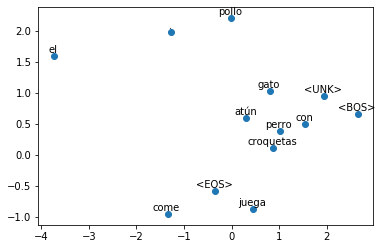

In [317]:
plt.scatter(npembs[:,0], npembs[:,1])
r=0
for label,x,y in zip(index_to_w, npembs[:,0], npembs[:,1]):
    plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
    r+=1
plt.show()

In [318]:
index_to_w

['el',
 '.',
 'juega',
 'pollo',
 'gato',
 'perro',
 'come',
 'con',
 'croquetas',
 'atún',
 '<BOS>',
 '<EOS>',
 '<UNK>']

In [319]:
# params[0][1]